In [3]:
import pickle
import os
import re
import pandas as pd
import numpy as np

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

### Load Dev2vec:repos dataset

In [6]:
#the directory of pickle files
usr_dir = r'..\users'

In [7]:
#Load files in pickle format. There is a seperate pickle file per each developer.
def open_file(file_path):
    with open(file_path, "rb") as picklefile:
        reader = pickle.load(picklefile)
    return(reader)

In [8]:
#Seprate lines in text with \n only (replace other newline tags with \n)
def newline(text):
    return '\n'.join([p for p in re.split(r'\\n|\\r|\\n\\n|\\r\\n|\r\n', text) if len(p) > 0])

In [9]:
#merge a list of readme files in a single string which are seperated with \n 
def merg_RM(RM):
    return '\n '.join(RM)

In [10]:
#merge to texts in one single text
def merg_text(txt1,txt2):
    return txt1 +"\n "+txt2

In [85]:
col_name= ['Name','u_id','bio','Repo_Name','ReadMe','tags','topics','textual_all']
Corpus = pd.DataFrame(columns = col_name, dtype=object)

In [86]:
#loop over all files in a directory and collect required fields
for filename in os.listdir(usr_dir):
    file_path = os.path.join(usr_dir, filename)
    reader = open_file(file_path) 
    bio   = newline(str(reader['bio']))
    Name = str(reader['name'])
    try:
        u_id= str(reader['u_id'])
    except:
        u_id ="none"
        
    RM = []
    repo_name=[]
    repo_tags=[]
    repo_topics=[]
    repo_text=[]
    if(len(reader['repository'])>4):
        for row in range(0,len(reader['repository'])):
            repo_name_tmp = str(reader['repository'][row]['repo_name'])
            repo_RM_tmp = newline(str(reader['repository'][row]['readme']))
            repo_tags_tmp = str(reader['repository'][row]['topics'])
            repo_topics_tmp=newline(str(reader['repository'][row]['about']))
        
            repo_name.append(repo_name_tmp)
            RM.append(repo_RM_tmp)
            repo_tags.append(repo_tags_tmp)
            repo_topics.append(repo_topics_tmp)   
        
            repo_text_tmp = merg_text(merg_text(repo_tags_tmp,repo_topics_tmp),merg_text(repo_name_tmp,repo_RM_tmp))
            repo_text.append(repo_text_tmp)
        
        
        
        text_all = merg_RM(repo_text) 
        info_all = merg_text(bio,text_all)
    
    
    Corpus = Corpus.append({'Name':Name,'u_id':u_id,'bio':bio,'Repo_Name':repo_name,'ReadMe':RM,'tags':repo_tags,
                            'topics':repo_topics,'textual_all':info_all},ignore_index=True)
    

#### We want to seperate single-label developers

In [88]:
dt1=Corpus[['Name','u_id','textual_all']]

In [11]:
dt2 = pd.read_csv('..\git_data_single_label.csv')

In [92]:
dt_count_lb = dt2['label'].value_counts()

In [93]:
dt_count_lb

Frontend         598
Mobile           380
Backend          197
DataScientist    158
DevOps           127
Name: label, dtype: int64

In [94]:
hatches = ['XX','..','++','o','-']

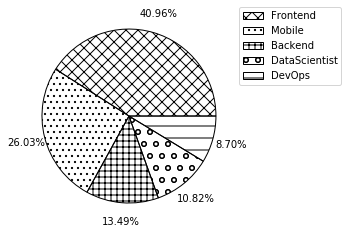

In [95]:
plt.figure(figsize=(5,4))
patches=plt.pie(dt_count_lb.values,autopct='%.2f%%', pctdistance=1.22)
for i in range(len(patches[0])):
    patches[0][i].set(hatch = hatches[i], fill=False)
plt.legend(dt_count_lb.index,bbox_to_anchor=(1.5,1.025),loc="upper right")
plt.savefig('jobroles.jpg', bbox_inches = 'tight',dpi=100)
plt.show()

In [96]:
merged_inner = pd.merge(left=dt1, right=dt2[['gh_login','label']], left_on='u_id', right_on='gh_login')

In [99]:
txt_dt=merged_inner[['u_id','textual_all','label']]

In [100]:
txt_dt.to_csv(r'..\dev2vec_repos_raw.csv', index=None, header=True)

In [101]:
#number of words before cleaning
txt_dt['textual_all'].apply(lambda x: len(x.split(' '))).sum()

24429870

### Clean Dev2vec:repos dataset

In [12]:
import gensim
from gensim.parsing.preprocessing import *

In [103]:
#store the textual_all in a sperate varaible
documents=txt_dt['textual_all']

In [13]:
#seperte sentences with \n
def split_sentence(corpus):
    sentences = [doc.split("\n") for doc in corpus]
    return sentences

In [14]:
#flat a list of lists into a list
def flatten_list(sentences):
    flatList = [ item.lower() for elem in sentences for item in elem]
    return flatList

In [15]:
#tokenize all sentences
def token_in_sentence(list_sentences):
    list_tokens = [list(gensim.utils.tokenize(doc, lower=True)) for doc in list_sentences]
    return list_tokens

In [16]:
#build a bundle of actions to clean data
def custom_filter():
    cstm_filter = [remove_stopwords,split_alphanum, strip_numeric, strip_tags, strip_non_alphanum]
    return cstm_filter

In [17]:
#cleaning data based on steps define in custom_filter
def str_preprocessing(tokenize_sentence):
    CUSTOM_FILTERS = custom_filter()
    tokens_new = preprocess_string(" ".join(tokenize_sentence), CUSTOM_FILTERS)
    return tokens_new

In [18]:
#get the possible phrases in the list of tokens
def get_bigram_token(model,tokens):
    bigrams = model[tokens]
    bi_tokens= [sent for sent in bigrams]
    return bi_tokens

In [110]:
#split sentence in documents (Corpus['textual_all'])
sentences_stream = split_sentence(txt_dt['textual_all'])

In [112]:
#tokenize all sentences
tokenize_sentence=[]
for row in sentences_stream:
    tokenize_st = flatten_list(token_in_sentence(row))
    tokenize_sentence.append(tokenize_st)

In [113]:
#cleaning data with costum actions
processing_tokens = [gensim.utils.simple_preprocess(sen) for sen in txt_dt['textual_all']]

In [114]:
#cleaning data with costum actions
processing_tokens = [str_preprocessing(sen) for sen in tokenize_sentence]

In [20]:
import nltk 

In [21]:
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\morad\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [22]:
words = set(nltk.corpus.words.words())

In [120]:
english_tokens=[]
for row in processing_tokens:
    english_tokens.append([w for w in row if w.lower() in words or not w.isalpha()])

In [121]:
clean_tokens=[]
for row in english_tokens:
    clean_tokens.append([w for w in row if len(w) > 2])

In [124]:
flatten_tokenize=flatten_list(clean_tokens)

In [125]:
# number of tokens after cleaning process
len(flatten_tokenize)

9135161

#### build a dataset for doctovec model

In [127]:
#build the data
dev2vec_repos = {'text_all':clean_tokens,'tags':txt_dt['u_id'],'label':txt_dt['label']}

In [128]:
dev2vec_repo_dt = pd.DataFrame(dev2vec_repos)

In [130]:
dev2vec_repo_dt.to_csv(r'..\dev2vec_repo_clean.csv', index=None, header=True)

## Load dev2vec:issues dataset

In [1]:
#the directory of pickle files for issues
issue_dir = r'..\issues'

In [23]:
col_name= ['Name','u_id','bio','Repo_Name','ReadMe','tags','topics','textual_all']
Issue_Corpus = pd.DataFrame(columns = col_name, dtype=object)

In [24]:
#loop over all files in a directory and collect required fields
issues=0
error=0
for filename in os.listdir(usr_dir):
    usr_path = os.path.join(usr_dir, filename)
    reader = open_file(usr_path)
    try:
        issue_path = os.path.join(issue_dir, filename)
        issue_reader = open_file(issue_path)
    except:
        issue_reader=None
        
    bio   = newline(str(reader['bio']))
    Name = str(reader['name'])
    try:
        u_id= str(reader['u_id'])
    except:
        u_id ="none"

        
   
    repo_name=[]
   
    issue_text=[]
    issue_txt_all=[]
    
    if(len(reader['repository'])>4):
        for row in range(0,len(reader['repository'])):
            repo_name_tmp = str(reader['repository'][row]['repo_name'])
           
        
            repo_name.append(repo_name_tmp)  
            
           
            
            try:
                if((issue_reader is not None) and (issue_reader['issues'][row])):
                    for j in issue_reader['issues'][row]:
                        issues=issues+1
                        issue_title= str(issue_reader['issues'][row][j]['title'])
                        issue_body= str(issue_reader['issues'][row][j]['body'])
                        issue_temp=merg_text(issue_title,issue_body)
                        issue_text.append(issue_temp)
            except:
                error=error+1
            
            issue_txt_all.append(issue_text)
            
            
            
                
        
      
            
        text_all = merg_RM(issue_txt_all) 
      
    
        Issue_Corpus = Issue_Corpus.append({'Name':Name,'u_id':u_id,'bio':bio,'Repo_Name':repo_name,
                            'textual_all':text_all},ignore_index=True)

In [25]:
len(Issue_Corpus)

1615

In [26]:
dt3=Issue_Corpus[['Name','u_id','textual_all']]

In [27]:
merged_inner_issue = pd.merge(left=dt3, right=dt2[['gh_login','label']], left_on='u_id', right_on='gh_login')

In [28]:
len(merged_inner_issue)

1306

In [29]:
issue_txt_dt=merged_inner_issue[['u_id','textual_all','label']]

In [57]:
issue_txt_dt.to_csv(r'..\dev2vec_issues_raw.csv', index=None, header=True)

In [30]:
#number of words before cleaning
issue_txt_dt['textual_all'].apply(lambda x: len(x.split(' '))).sum()

2593012

## Clean dev2vec:issues data

In [31]:
#split sentence in documents (Corpus['textual_all'])
issue_sentences_stream = split_sentence(issue_txt_dt['textual_all'])

In [41]:
#tokenize all sentences
issue_tokenize_sentence=[]
for row in issue_sentences_stream:
    tokenize_st = flatten_list(token_in_sentence(row))
    issue_tokenize_sentence.append(tokenize_st)

In [43]:
#cleaning data with costum actions
issue_processing_tokens = [str_preprocessing(sen) for sen in issue_tokenize_sentence]

In [45]:
issue_english_tokens=[]
for row in issue_processing_tokens:
    issue_english_tokens.append([w for w in row if w.lower() in words or not w.isalpha()])

In [46]:
issue_clean_tokens=[]
for row in issue_english_tokens:
    issue_clean_tokens.append([w for w in row if len(w) > 2])

In [49]:
flatten_tokenize=flatten_list(issue_clean_tokens)

In [50]:
# number of tokens after cleaning process
len(flatten_tokenize)

978445

In [51]:
#build the model
dev2vec_issues = {'text_all':issue_clean_tokens,'tags':issue_txt_dt['u_id'],'label':issue_txt_dt['label']}

In [53]:
dev2vec_issues_dt = pd.DataFrame(dev2vec_issues)

In [56]:
dev2vec_issues_dt.to_csv(r'..\dev2vec_issue_clean.csv', index=None, header=True)